## Importing Packages

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = '/content/drive/MyDrive/Dataset/archive (14).zip'  # correct name
extract_path = '/content/drive/MyDrive/Dataset/'

import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
import os

base_dir = '/content/drive/MyDrive/Dataset'
print("Contents of Dataset folder:", os.listdir(base_dir))

Contents of Dataset folder: ['archive (14).zip', 'covid_update']


In [5]:
import os

base_dir = '/content/drive/MyDrive/Dataset/covid_update'
train_dir = os.path.join(base_dir, 'Train')       # or 'train' if it's lowercase
validation_dir = os.path.join(base_dir, 'Test')   # or 'test' if it's lowercase

# Check contents
print("Train directory:", os.listdir(train_dir))
print("Test directory:", os.listdir(validation_dir))

Train directory: ['covid', 'non_covid']
Test directory: ['covid', 'non_covid']


# Understanding the Data

In [6]:
train_covid_dir = os.path.join(train_dir, 'covid')
train_non_covid_dir = os.path.join(train_dir, 'non_covid')

validation_covid_dir = os.path.join(validation_dir, 'covid')
validation_non_covid_dir = os.path.join(validation_dir, 'non_covid')

In [7]:
num_covid_tr = len(os.listdir(train_covid_dir))
num_non_covid_tr = len(os.listdir(train_non_covid_dir))  # corrected name

num_covid_val = len(os.listdir(validation_covid_dir))
num_non_covid_val = len(os.listdir(validation_non_covid_dir))  # corrected name

total_train = num_covid_tr + num_non_covid_tr
total_val = num_covid_val + num_non_covid_val

In [8]:
print('total training covid images:', num_covid_tr)
print('total training non_covid images:', num_non_covid_tr)

print('total validation covid images:', num_covid_val)
print('total validation non_covid images:', num_non_covid_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training covid images: 250
total training non_covid images: 203
total validation covid images: 100
total validation non_covid images: 119
--
Total training images: 453
Total validation images: 219


# Setting Model Parameters

In [9]:
Batch_Size = 16
Image_Size = 500

#Data Augmentation
### Creating Training data generator

In [10]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      )

train_data_gen = image_gen_train.flow_from_directory(batch_size=Batch_Size,
                                                     directory=train_dir,
                                                     color_mode = 'grayscale',
                                                     target_size=(Image_Size,Image_Size),
                                                     class_mode='binary')

Found 453 images belonging to 2 classes.


# Visualizing the Data

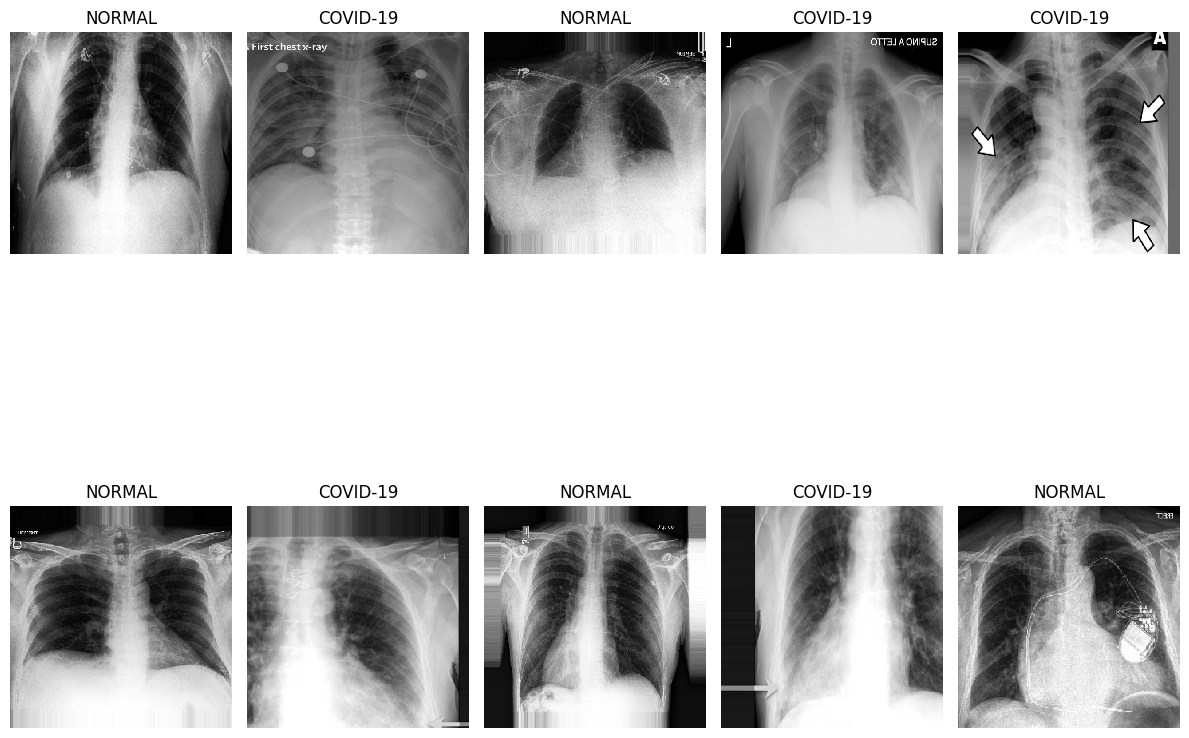

In [11]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch, Y_batch in train_data_gen:
        image = X_batch[0]
        dic = {0:'COVID-19', 1:'NORMAL'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# Creating Validation Data generator

In [12]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=Batch_Size,
                                                 directory=validation_dir,
                                                 color_mode = 'grayscale',
                                                 shuffle=False,
                                                 target_size=(Image_Size, Image_Size),
                                                 class_mode='binary')

Found 219 images belonging to 2 classes.


# Model Creation
## Define the model

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(500, 500, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),


    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compiling the model

In [14]:
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model Summary

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 498, 498, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 249, 249, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 247, 247, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 123, 123, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 121, 121, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,959,618 (7.48 MB)

 Trainable params: 1,959,618 (7.48 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [16]:
epochs = 15
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(Batch_Size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(Batch_Size)))
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


29/29 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - accuracy: 0.5570 - loss: 0.6890 - val_accuracy: 0.7078 - val_loss: 0.6146
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 177s 6s/step - accuracy: 0.7904 - loss: 0.5095 - val_accuracy: 0.7260 - val_loss: 0.4885
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - accuracy: 0.8647 - loss: 0.3869 - val_accuracy: 0.8402 - val_loss: 0.3462
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.9109 - loss: 0.2181 - val_accuracy: 0.6027 - val_loss: 0.6678
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 217s 6s/step - accuracy: 0.7780 - loss: 0.4114 - val_accuracy: 0.8584 - val_loss: 0.3483
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 174s 6s/step - accuracy: 0.9216 - loss: 0.1751 - val_accuracy: 0.9132 - val_loss: 0.2105
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.8777 - loss: 0.3356 - val_accuracy: 0.8767 - val_loss: 0.3028
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 181s 6s/step - accuracy: 0.8934 - loss: 0.2983 - val_accuracy: 0.9041 - val_loss: 0.

# Model Architecture

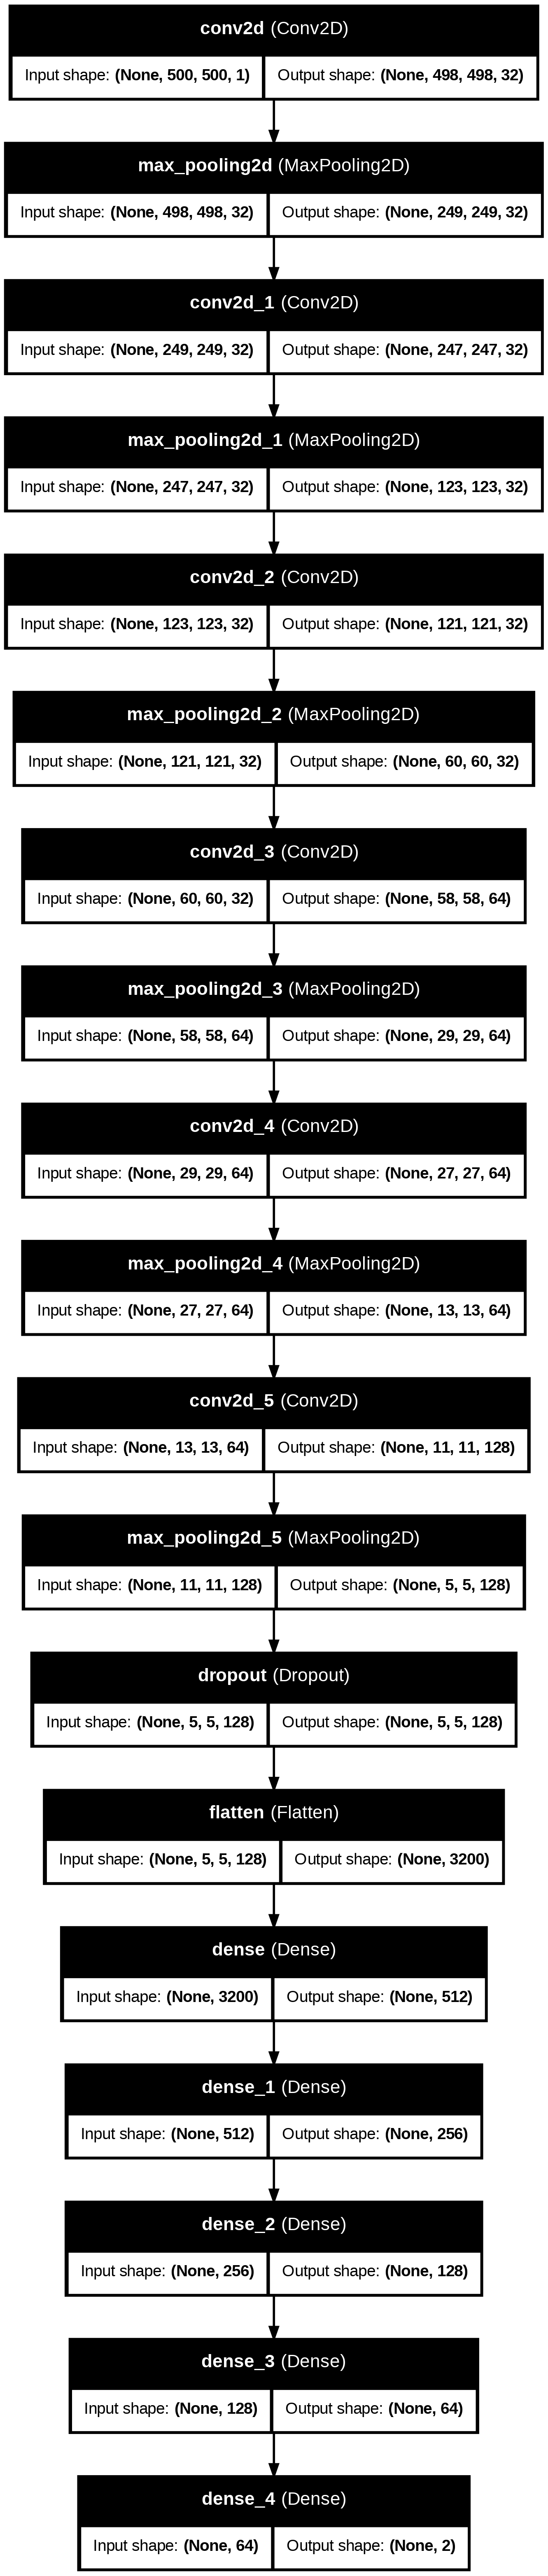

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

# Visualizing results of the training

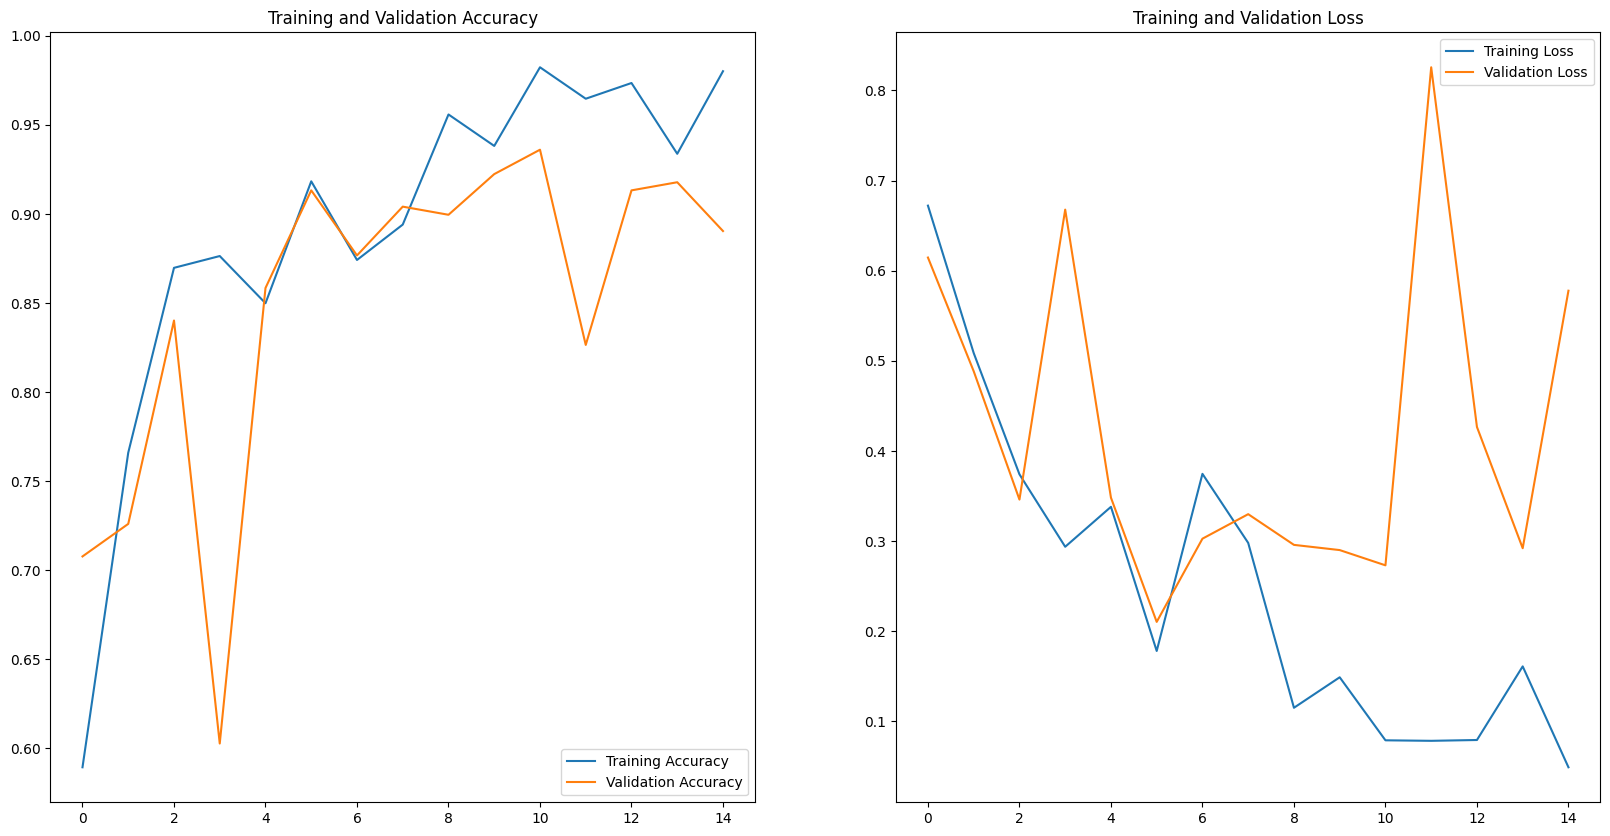

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Visualizing the accuracy and loss on Training and Validation data

<Axes: >

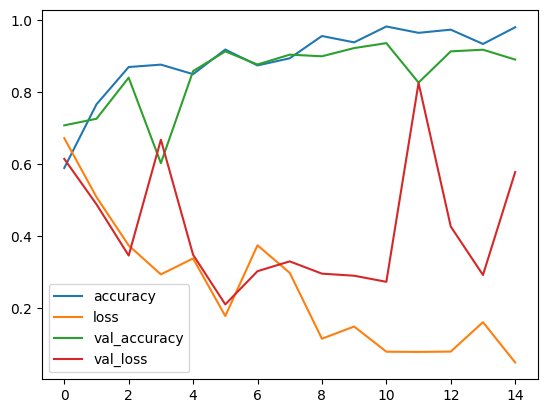

In [19]:
pd.DataFrame(model.history.history).plot()

## Loss on Training Data

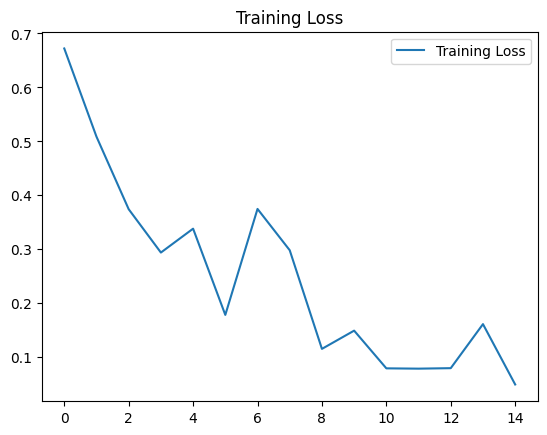

In [20]:
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

##Loss on Validation Data

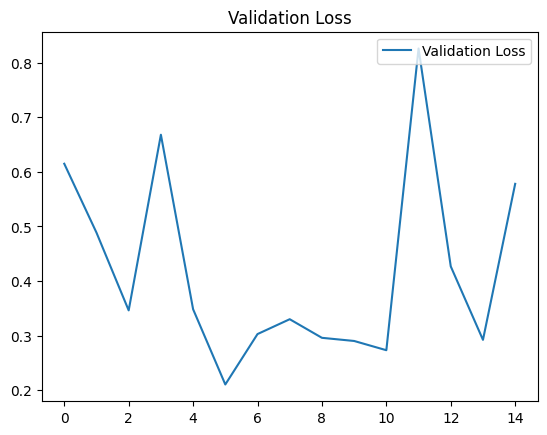

In [21]:
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()

# Determining the accuracy of the model on Validation Data

In [22]:
test_accu = model.evaluate(val_data_gen)
print('The testing accuracy is :',test_accu[1]*100, '%')



14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8131 - loss: 0.9276
The testing accuracy is : 89.04109597206116 %


# Determining the accuracy of the model on Training Data

In [23]:
train_accu = model.evaluate(train_data_gen)
print('The training accuracy is :',train_accu[1]*100, '%')

29/29 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9766 - loss: 0.0398
The training accuracy is : 97.35099077224731 %


#Result Analysis using Classification Report

In [24]:

validation_steps = int(np.ceil(total_val / float(Batch_Size)))

predictions = model.predict(val_data_gen, steps = validation_steps)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_data_gen.classes


report = classification_report(true_classes, predicted_classes, target_names=['COVID-19','NORMAL'])
print(report)



14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
              precision    recall  f1-score   support

    COVID-19       0.97      0.78      0.87       100
      NORMAL       0.84      0.98      0.91       119

    accuracy                           0.89       219
   macro avg       0.91      0.88      0.89       219
weighted avg       0.90      0.89      0.89       219



# Result Analysis using confusion matrix

<Axes: >

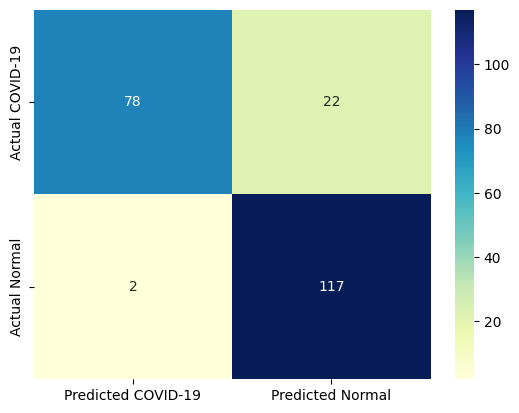

In [25]:
cm = pd.DataFrame(data=confusion_matrix(true_classes, predicted_classes, labels=[0, 1]),index=["Actual COVID-19", "Actual Normal"],
columns=["Predicted COVID-19", "Predicted Normal"])
sns.heatmap(cm,annot=True,fmt="d",cmap="YlGnBu")

14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step


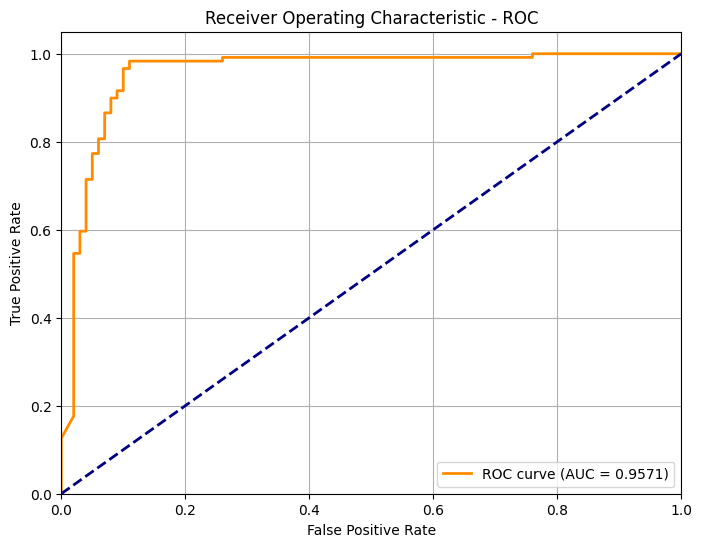

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions (probabilities, not classes)
y_pred_proba = model.predict(val_data_gen, steps=int(np.ceil(total_val / Batch_Size)))

# True labels
y_true = val_data_gen.classes

# If predictions have shape (N, 1), flatten them
if y_pred_proba.shape[1] == 1:
    y_scores = y_pred_proba.ravel()
else:  # if using softmax with 2 outputs
    y_scores = y_pred_proba[:, 1]  # probability for class "1" (NORMAL in your case)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()